In [1]:
!pip install -q tensorflow-gpu==2.0.0-rc1
!pip install -q h5py pyyaml

     |████████████████████████████████| 380.5MB 46kB/s 
     |████████████████████████████████| 4.3MB 49.8MB/s 
     |████████████████████████████████| 501kB 52.9MB/s 


In [2]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, Dense, Input, MaxPooling2D, Dropout, BatchNormalization, Activation, Concatenate, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, ZeroPadding2D
from tensorflow.keras import backend

import os
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt



## Data load(train, validation, test)

In [0]:
PATH = '/content/gdrive/My Drive/dataset'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')
test_cats_dir = os.path.join(test_dir, 'cat')
test_dogs_dir = os.path.join(test_dir, 'dog')

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

num_cats_test = len(os.listdir(test_cats_dir))
num_dogs_test = len(os.listdir(test_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
total_test= num_cats_test + num_dogs_test

print(total_train)
print(total_val)
print(total_test)

17000
4000
4000


## Visualize with each data graph

In [0]:
# 데이터 확인 함수
def check_images(train_path, val_path, test_path):
  train_cat_path = os.path.join(train_path,"cat")
  train_dog_path = os.path.join(train_path,"dog")
  val_cat_path = os.path.join(val_path,"cat")
  val_dog_path = os.path.join(val_path,"dog")
  test_cat_path = os.path.join(test_path,"cat")
  test_dog_path = os.path.join(test_path,"dog")

  num_cats_tr = len(os.listdir(train_cat_path))
  num_dogs_tr = len(os.listdir(train_dog_path))
  num_cats_val = len(os.listdir(val_cat_path))
  num_dogs_val = len(os.listdir(val_dog_path))
  num_cats_test = len(os.listdir(test_cat_path))
  num_dogs_test = len(os.listdir(test_dog_path))
  label = ['train', 'valid','test']
  cat = [num_cats_tr,num_cats_val,num_cats_test]
  dog = [num_dogs_tr,num_dogs_val,num_dogs_test]

  plt.rcParams["font.size"] = 12

  plt.figure(figsize=(12,8))

  x = np.arange(len(label))

  p1 = plt.bar(x-0.15, cat, label='cat', width=0.3, color='#FFE6EB')
  p2 = plt.bar(x+0.15, dog, label='dog', width=0.3, color='#36E0C6')

  for i, rect in enumerate(p1):
      plt.text(rect.get_x() + rect.get_width() / 2.0, 0.95 * rect.get_height(), str(cat[i]), ha='center')
  for i, rect in enumerate(p2):
      plt.text(rect.get_x() + rect.get_width() / 2.0, 0.95 * rect.get_height(), str(dog[i]), ha='center')
  plt.legend((p1[0], p2[0]), ('1','0'), fontsize = 15)

  plt.xticks(x, label)
  plt.ylabel('Number of data')
  plt.title('Dogs-vs-Cats Data')

  plt.show()
  return

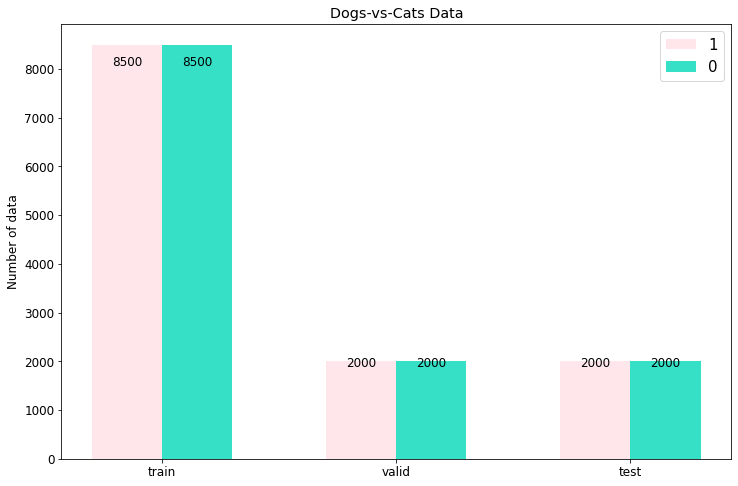

In [6]:
check_images(train_dir, validation_dir, test_dir)

## Hyperparameter initialization and dataset, load configuration

In [0]:
batch_size = 20
epochs = 250
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [0]:
train_image_generator = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

validation_image_generator = ImageDataGenerator(rescale=1./255)

test_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 17000 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 4000 images belonging to 2 classes.


In [0]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                         directory=test_dir,
                                                         shuffle=False,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='binary')                                                      

Found 4000 images belonging to 2 classes.


## Model design, detailed configuration of model-related parameter(optimization, loss function, metrics, etc.)

In [0]:
def conv_block(x, growth_rate, name):
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    x = Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x

In [0]:
def dense_block(x, blocks, name):
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

In [0]:
def transition_block(x, reduction, name):
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv2D(int(backend.int_shape(x)[bn_axis] * reduction), 1, use_bias=False, name=name + '_conv')(x)
    x = AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

In [0]:
layers_in_block = {'DenseNet-121': [6, 12, 24, 16],
                   'DenseNet-169': [6, 12, 32, 32],
                   'DenseNet-201': [6, 12, 48, 32],
                   'DenseNet-265': [6, 12, 64, 48]}

In [0]:
input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input')

In [0]:
def DenseNet(model_input, classes=1, densenet_type='DenseNet-121', pooling='avg'):
  bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

  x = ZeroPadding2D(padding=((3, 3), (3, 3)))(model_input)
  x = Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv')(x)
  x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
  x = Activation('relu', name='conv1/relu')(x)
  x = ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
  x = MaxPooling2D(3, strides=2, name='pool1')(x)

  x = dense_block(x, layers_in_block[densenet_type][0], name='conv2')
  x = transition_block(x, 0.5, name='pool2')
  x = dense_block(x, layers_in_block[densenet_type][1], name='conv3')
  x = transition_block(x, 0.5, name='pool3')
  x = dense_block(x, layers_in_block[densenet_type][2], name='conv4')
  x = transition_block(x, 0.5, name='pool4')
  x = dense_block(x, layers_in_block[densenet_type][3], name='conv5')

  x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
  x = Activation('relu', name='relu')(x)

  if pooling == 'avg':
      x = GlobalAveragePooling2D(name='avg_pool')(x)
  elif pooling == 'max':
      x = GlobalMaxPooling2D(name='max_pool')(x)

  model_output = Dense(classes, activation='sigmoid')(x)

  model = Model(inputs = model_input, outputs = model_output)

  return model

In [0]:
DenseNet121 = DenseNet(input_tensor, classes=1, densenet_type='DenseNet-121')

DenseNet121.summary()

In [0]:
SGD = optimizers.SGD(lr=0.001, momentum=0.9)

DenseNet121.compile(
    loss='binary_crossentropy',
    optimizer=SGD,
    metrics=['accuracy']
)

## Model learning (with parameters such as checkpoints, steps, epochs, data, etc.)

In [0]:
history = DenseNet121.fit_generator(
    train_data_gen,
    steps_per_epoch=80,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=20
)

## View model learning graphs (250 epochs)

Text(0.5, 1.0, 'Training and Validation Loss')

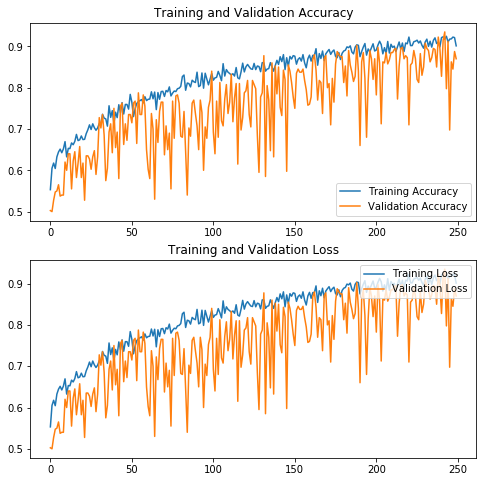

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, acc, label='Training Loss')
plt.plot(epochs_range, val_acc, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

## Assess learning model and confirm prediction

In [0]:
DenseNet121 = tf.keras.models.load_model('/content/gdrive/My Drive/dataset/DenseNet121_avg_250.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#epoch 250
print("Evaluate")
DenseNet121.evaluate_generator(test_data_gen, steps=200, verbose=1)

Evaluate
200/200 [==============================] - 1611s 8s/step - loss: 0.2896 - acc: 0.8687


[0.28962568229064345, 0.86875]

In [0]:
print("Predict")
pred = DenseNet121.predict_generator(test_data_gen, steps=200, verbose=1)

Predict
200/200 [==============================] - 36s 179ms/step


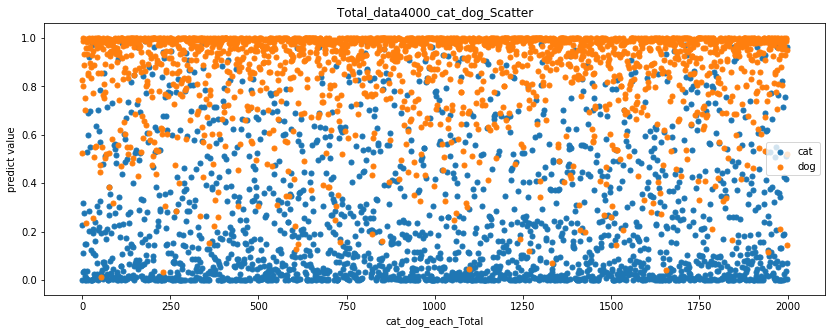

In [0]:
#test_ predict 예측값 분포도(4000개)

plt.figure(figsize=(14, 5))
plt.title('Total_data4000_cat_dog_Scatter')
plt.xlabel('cat_dog_each_Total')
plt.ylabel('predict value')
plt.scatter(range(2000), pred[:2000], s=25, label='cat')
plt.scatter(range(2000), pred[2000:], s=25, label='dog')
plt.legend()
plt.show()

## Feature map (one layer or one layer each).

In [0]:
#분류 작업

predict_data = []

for i in range(len(pred)):
  if pred[i] > 0.5:
    predict_data.append(1)
  else:
    predict_data.append(0)

Confusion Matrix


Text(33.0, 0.5, 'true value')

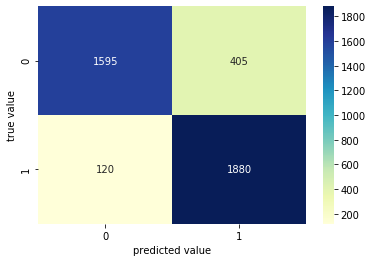

In [0]:
#confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix')
conf_matrix = confusion_matrix(test_data_gen.classes, predict_data)
sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

(1, 224, 224, 3)


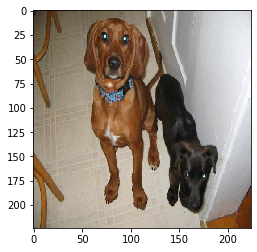

In [0]:
#feature map 

#test_image 한개 접근
test_image = Image.open('/content/gdrive/My Drive/dataset/test/dog/dog.89.jpg').resize((224, 224))

img_tensor = image.img_to_array(test_image)
img_tensor = np.expand_dims(img_tensor, axis=0)
test_data = img_tensor / 255.0


plt.imshow(test_image)

print(test_data.shape)

In [0]:
#모델 예측 확인
pred_test = DenseNet121.predict(test_data)

print(pred_test)

[[0.99998534]]


In [0]:
def Layer_predict(model, image):
  output_layers = [layer.output for layer in model.layers[:427] if 'v' ==  '{}'.format(layer.name[-1])]
  output_names = [layer.name for layer in model.layers[:427] if 'v' == '{}'.format(layer.name[-1])]
  print(output_names)
  show_model = tf.keras.models.Model(inputs = model.input, outputs = output_layers)
  # 예측_A
  show_model_pred = show_model.predict(image)
  #print(model_A_pred[0])
  for k, pred_layer in enumerate(show_model_pred):
    print(k, pred_layer.shape)
  return show_model_pred, output_names

In [0]:
layer_outputs, layer_names = Layer_predict(DenseNet121, test_data)

In [0]:
#각 층의 1개의 피쳐 맵 가져오기
def show_activation_maps(layer, title, i):
  plt.subplot(8, 15, i+1)
  plt.axis('off')
  if i> 31 :
    i -= i + 1
  plt.matshow(layer[0, :, :, i], fignum=0)

conv_layers(Total : 119)


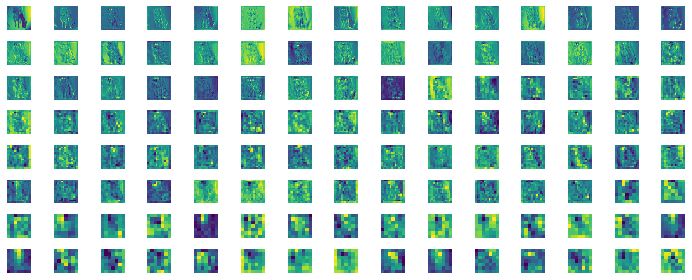

In [0]:
plt.figure(figsize=(10, 4))
for i, (layer, name) in enumerate(zip(layer_outputs, layer_names)):
  show_activation_maps(layer, name, i)
  
print('conv_layers(Total : {})'.format(i))  
plt.tight_layout()
plt.show()

## Grad CAM(filter 512 conv_2d layer commit, cat, dog)

In [0]:
#모델 전체 구성 레이어 층 및 이름 확인.

for i in range(428):
  weights = DenseNet121.get_layer(index=i).output

  print(i, weights)


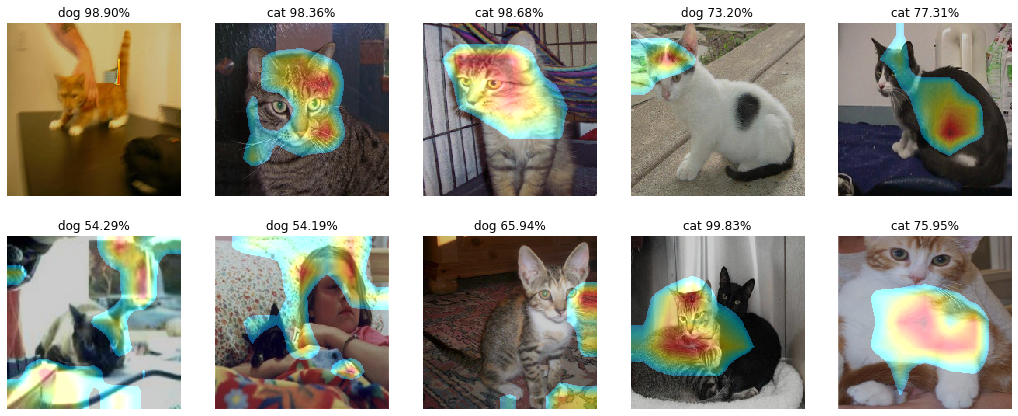

In [0]:
import cv2
plt.figure(figsize=(18, 15))
for i in range(10):
    img = cv2.imread('/content/gdrive/My Drive/dataset/test/cat/cat.%d.jpg'%i)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    x = img.copy()
    x.astype(np.float32)
    x = x / 255.0
    
    grad_model = tf.keras.models.Model(
        [DenseNet121.inputs], [DenseNet121.get_layer(index=399).output, DenseNet121.output]
    )

    with tf.GradientTape() as tape:
      x = np.expand_dims(x, axis=0)
      inputs = tf.cast(x, tf.float32)
      model_outputs, predictions = grad_model(inputs)
      loss = predictions[:,0]

    grads = tape.gradient(loss, model_outputs)

    guided_grads = (
        tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
    )

    prediction = predictions[0]
    base_model_outputs = model_outputs[0]
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    weights = np.mean(grads, axis=(1, 2))
    weights = weights.reshape(128, 1)

    cam = (prediction - 0.3) * np.matmul(base_model_outputs, weights)
    #cam -= np.min(cam)
    cam /= np.max(cam)
    cam -= 0.2
    cam /= 0.8
    
    cam = cv2.resize(np.float32(cam), (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.3)] = 0

    
    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
    plt.axis('off')
    plt.imshow(out[:,:,::-1])

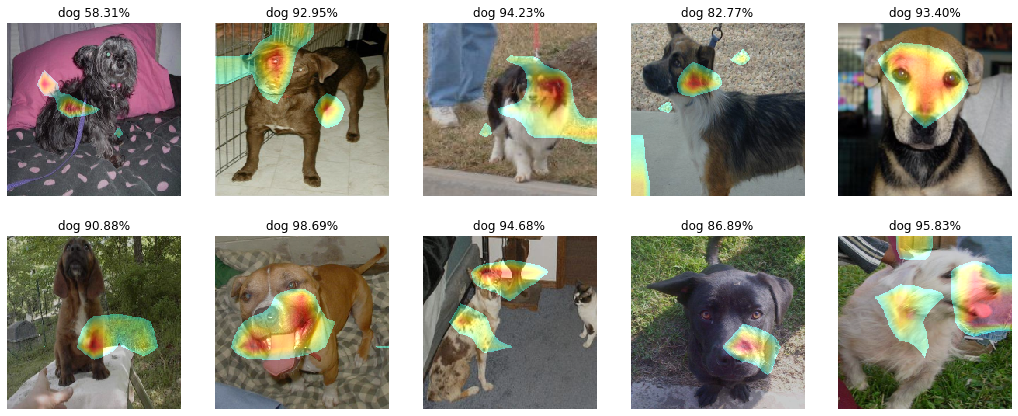

In [0]:
import cv2
plt.figure(figsize=(18, 15))
for i in range(10):
    img = cv2.imread('/content/gdrive/My Drive/dataset/test/dog/dog.%d.jpg'%i)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    x = img.copy()
    x.astype(np.float32)
    x = x / 255.0
    
    grad_model = tf.keras.models.Model(
        [DenseNet121.inputs], [DenseNet121.get_layer(index=392).output, DenseNet121.output]
    )

    with tf.GradientTape() as tape:
      x = np.expand_dims(x, axis=0)
      inputs = tf.cast(x, tf.float32)
      model_outputs, predictions = grad_model(inputs)
      loss = predictions[:,0]

    grads = tape.gradient(loss, model_outputs)

    guided_grads = (
        tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
    )

    prediction = predictions[0]
    base_model_outputs = model_outputs[0]
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    weights = np.mean(grads, axis=(1, 2))
    weights = weights.reshape(128, 1)

    cam = (prediction -0.3) * np.matmul(base_model_outputs, weights)
    #cam -= np.min(cam)
    cam /= np.max(cam)
    cam -= 0.2
    cam /= 0.8
    
    cam = cv2.resize(np.float32(cam), (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.4)] = 0

    
    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
    plt.axis('off')
    plt.imshow(out[:,:,::-1])